In [160]:
import numpy as np
import pandas as pd
from ISLP import load_data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm 
from ISLP.models import (summarize,poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from matplotlib.pyplot import subplots
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
from sklearn.model_selection import train_test_split


Applied

6. In this exercise, you will further analyze the Wage data set considered
throughout this chapter.
(a) Perform polynomial regression to predict wage using age. Use
cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to
the results of hypothesis testing using ANOVA? Make a plot of
the resulting polynomial fit to the data.

In [5]:
wage = load_data('Wage')
wage

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [6]:
age =  wage['age'].values.reshape(-1,1)
y = wage['wage'].values
age.shape


(3000, 1)

In [7]:
scores = []
for degree in range(1,7):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(age)
    model = LinearRegression()
    scores.append(-1 * np.mean(cross_val_score(model,X_poly,y,cv=5,scoring='neg_mean_squared_error')))

scores

[1675.0142380530044,
 1599.5982268539044,
 1594.7262162596821,
 1593.9141039297458,
 1595.433131541959,
 1594.9302253022665]

In [8]:
models = []
for d in range(1,7):
    poly = PolynomialFeatures(d)
    X_poly = poly.fit_transform(age)
    model = sm.OLS(y,sm.add_constant(X_poly)).fit()
    models.append(model)


In [9]:
anova_lm(*models)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.663571,2.285169e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.893609,1.674794e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.811683,5.098933e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.805371,3.695646e-01
5,2993.0,4.766389e+06,1.0,3932.256955,2.469216,1.162015e-01


- degree 3 was chosen because its significant and higher degrees does not seem statistically significant.

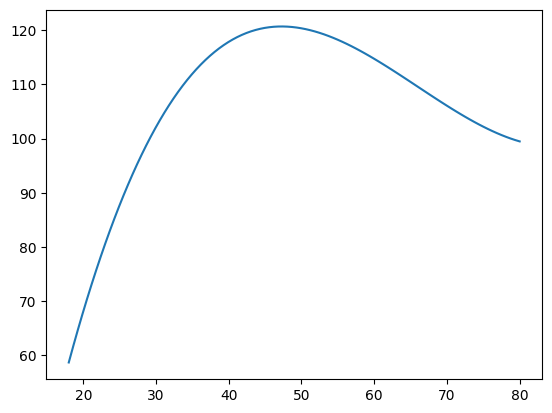

In [10]:
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(age) 
age_grid = np.linspace(age.min(),age.max(),100).reshape(-1,1)
age_grid_poly = poly.transform(age_grid)
model = sm.OLS(y,sm.add_constant(X_poly)).fit()

preds = model.predict(sm.add_constant(age_grid_poly))
plt.plot(age_grid,preds)

(b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number of cuts. Make a plot of
the fit obtained.

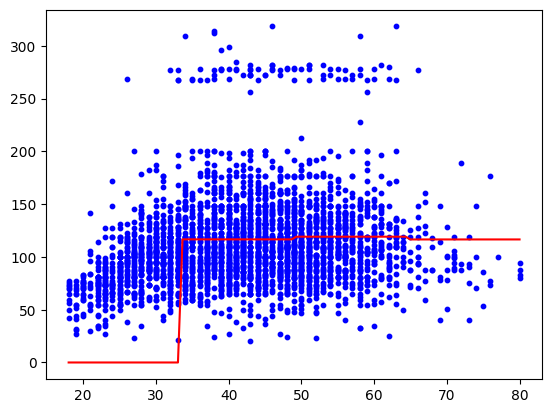

In [11]:
cut_age = pd.qcut(wage['age'],4)
model = sm.OLS(y,pd.get_dummies(cut_age,drop_first=True)).fit()
age_grid = np.linspace(wage['age'].min(), wage['age'].max(), 100)
cut_age_grid = pd.qcut(age_grid,4)
cut_age_grid = pd.get_dummies(cut_age_grid,drop_first=True)

preds_step = model.predict(cut_age_grid)
plt.scatter(wage['age'], y, color='blue', label='Original Data', s=10)
plt.plot(age_grid,preds_step,color='red')

7. The Wage data set contains a number of other features not explored
in this chapter, such as marital status (maritl), job class (jobclass),
and others. Explore the relationships between some of these other
predictors and wage, and use non-linear fitting techniques in order to
fit flexible models to the data. Create plots of the results obtained,
and write a summary of your findings.

In [12]:
X = wage.drop(columns=['wage','logwage'],axis=1)
y = wage.wage.values


In [13]:
X_encoded = pd.get_dummies(X,drop_first=True)
X_encoded

,year,age,maritl_2. Married,maritl_3. Widowed,maritl_4. Divorced,maritl_5. Separated,race_2. Black,race_3. Asian,race_4. Other,education_2. HS Grad,education_3. Some College,education_4. College Grad,education_5. Advanced Degree,jobclass_2. Information,health_2. >=Very Good,health_ins_2. No
0,2006,18,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2004,24,False,False,False,False,False,False,False,False,False,True,False,True,True,True
2,2003,45,True,False,False,False,False,False,False,False,True,False,False,False,False,False
3,2003,43,True,False,False,False,False,True,False,False,False,True,False,True,True,False
4,2005,50,False,False,True,False,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,True,False,False,False,False,False,False,False,True,False,False,False,True,False
2996,2007,30,True,False,False,False,False,False,False,True,False,False,False,False,True,True
2997,2005,27,True,False,False,False,True,False,False,False,False,False,False,False,False,True
2998,2005,27,False,False,False,False,False,False,False,False,True,False,False,False,True,False


In [14]:
wage.columns

Index(['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass',
       'health', 'health_ins', 'logwage', 'wage'],
      dtype='object')

In [15]:
X_encoded.dtypes

year                            int64
age                             int64
maritl_2. Married                bool
maritl_3. Widowed                bool
maritl_4. Divorced               bool
maritl_5. Separated              bool
race_2. Black                    bool
race_3. Asian                    bool
race_4. Other                    bool
education_2. HS Grad             bool
education_3. Some College        bool
education_4. College Grad        bool
education_5. Advanced Degree     bool
jobclass_2. Information          bool
health_2. >=Very Good            bool
health_ins_2. No                 bool
dtype: object

In [16]:
X_encoded = sm.add_constant(np.asarray(X_encoded))

In [17]:
X_encoded = X_encoded.astype(float)
model = sm.OLS(y,X_encoded).fit()
summarize(model)

,coef,std err,t,P>|t|
const,-2423.3291,616.543,-3.931,0.000
x1,1.2412,0.307,4.037,0.000
x2,0.2707,0.062,4.350,0.000
x3,17.1767,1.720,9.985,0.000
x4,2.0517,8.005,0.256,0.798
x5,3.9666,2.887,1.374,0.170
x6,11.5301,4.844,2.380,0.017
x7,-5.0963,2.146,-2.375,0.018
x8,-2.8141,2.603,-1.081,0.280
x9,-6.0588,5.666,-1.069,0.285


<Axes: xlabel='maritl', ylabel='wage'>

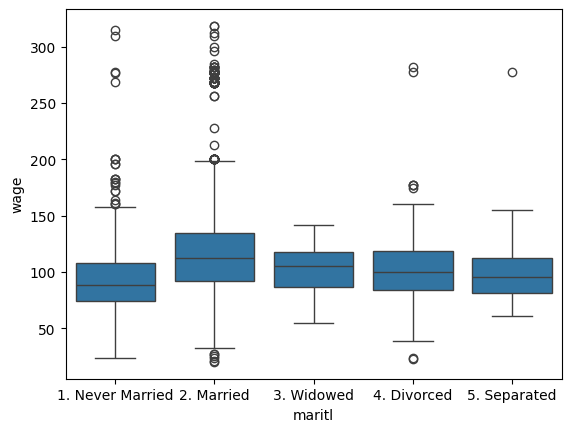

In [18]:
sns.boxplot(x=wage['maritl'],y='wage',data=wage)

<Axes: xlabel='education', ylabel='wage'>

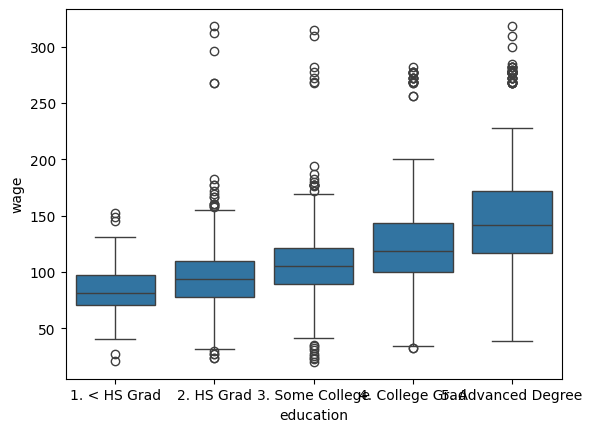

In [19]:
sns.boxplot(x=wage['education'],y='wage',data=wage)

<Axes: xlabel='race', ylabel='wage'>

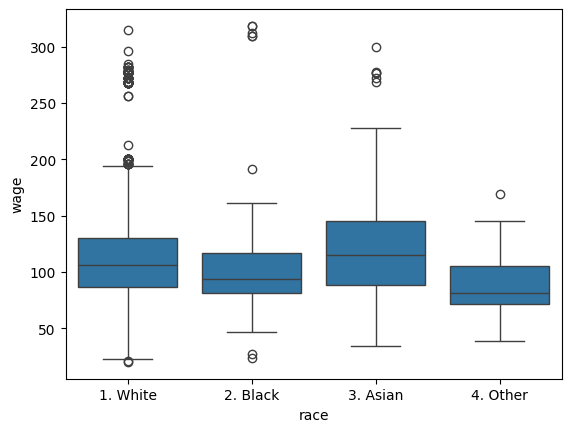

In [20]:
sns.boxplot(x=wage['race'],y=wage.wage,data=wage)

<Axes: xlabel='health', ylabel='wage'>

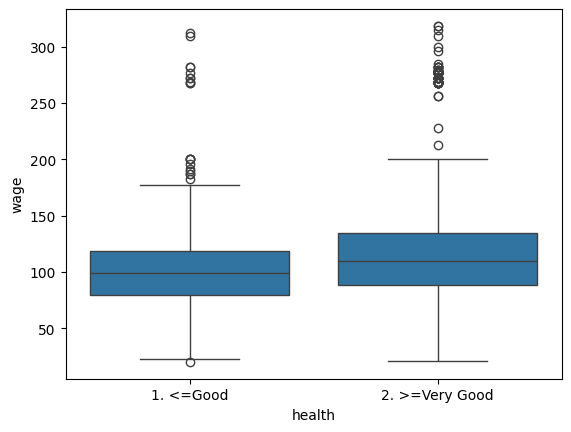

In [21]:
sns.boxplot(x=wage['health'],y=wage['wage'],data=wage)

<Axes: xlabel='jobclass', ylabel='wage'>

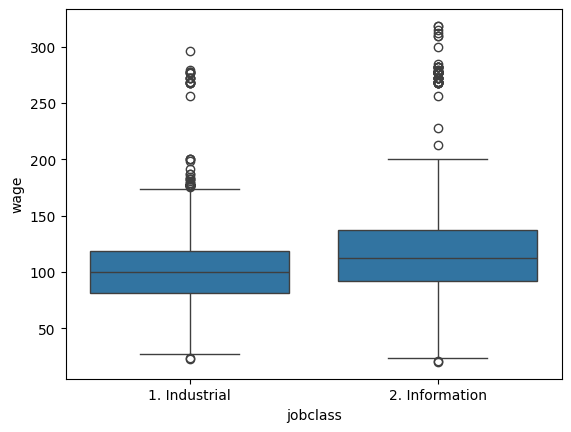

In [22]:
sns.boxplot(x=wage['jobclass'],y=wage.wage,data=wage)

In [23]:
year = wage['year']
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(year)
Xs = [ns_age.transform(age),ns_year.transform(year),pd.get_dummies(wage['education']).values, pd.get_dummies(wage['maritl']).values,pd.get_dummies(wage['health']),
      pd.get_dummies(wage['jobclass']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y,X_bh).fit()

In [24]:
gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2,lam=0) + f_gam(3,lam=0) + f_gam(4,lam=0) + f_gam(5,lam=0))
X_gam = np.column_stack([age,year,wage['education'].cat.codes,wage['maritl'].cat.codes,wage['health'].cat.codes,wage['jobclass'].cat.codes])
gam_full = gam_full.fit(X_gam,y)

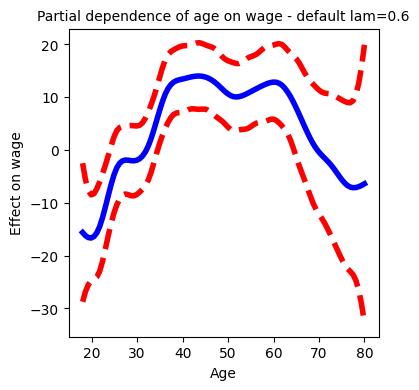

In [25]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


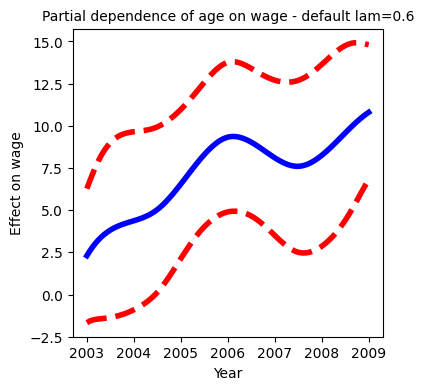

In [26]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


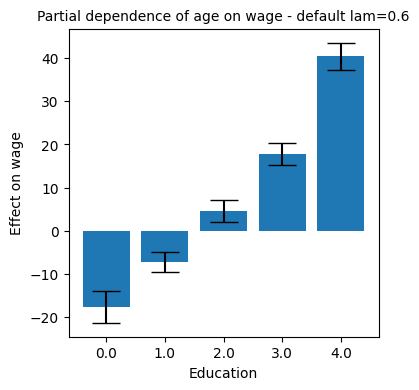

In [27]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 2, ax=ax)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


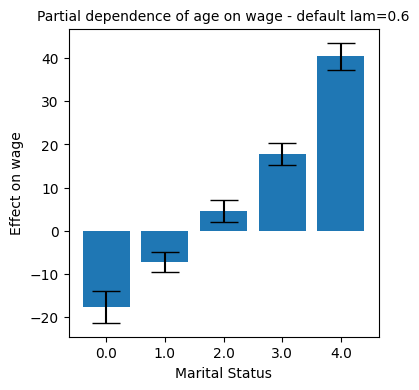

In [28]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 3, ax=ax)
ax.set_xlabel('Marital Status')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


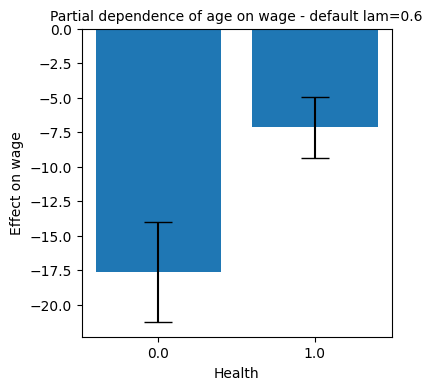

In [29]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 4, ax=ax)
ax.set_xlabel('Health')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


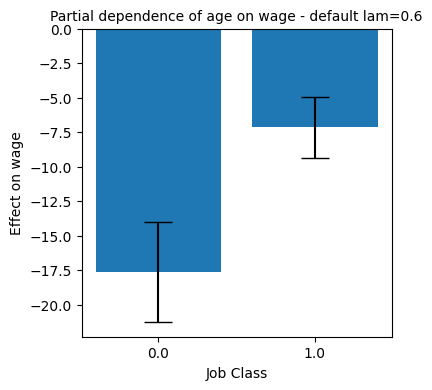

In [30]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 5, ax=ax)
ax.set_xlabel('Job Class')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


8. Fit some of the non-linear models investigated in this chapter to the
Auto data set. Is there evidence for non-linear relationships in this
data set? Create some informative plots to justify your answer.

In [31]:
auto = pd.read_csv('Auto.csv')
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


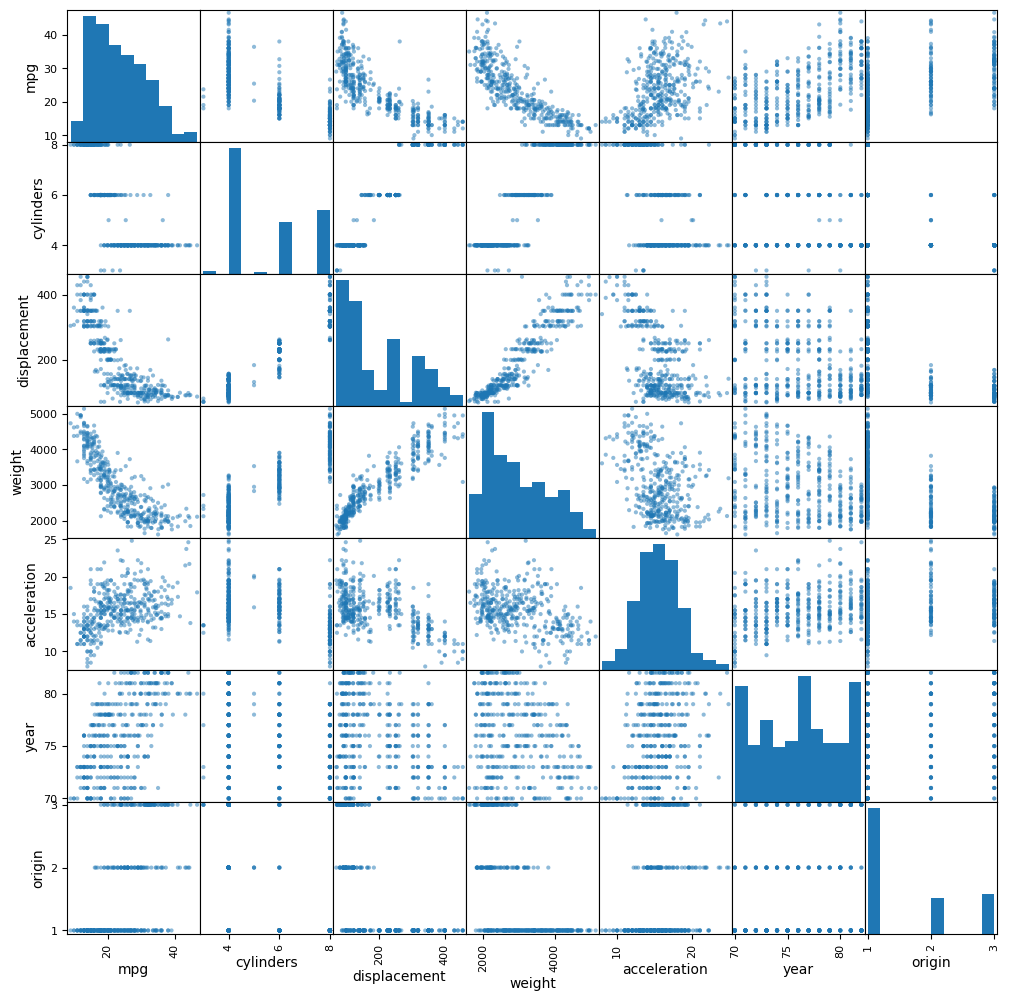

In [32]:
pd.plotting.scatter_matrix(auto,figsize=(12,12));

In [33]:
X_auto = auto[['displacement','weight','acceleration']]
gam = LinearGAM(s_gam(0)+s_gam(1)+s_gam(2)).fit(X_auto,auto['mpg'])


In [34]:
displacement_grid = np.linspace(auto['displacement'].min(),auto['displacement'].max(),100).reshape(-1,1)
weight_grid = np.linspace(auto['weight'].min(),auto['weight'].max(),100).reshape(-1,1)
acceleration_grid = np.linspace(auto['acceleration'].min(),auto['acceleration'].max(),100).reshape(-1,1)
X_grid = np.hstack([displacement_grid,weight_grid,acceleration_grid])


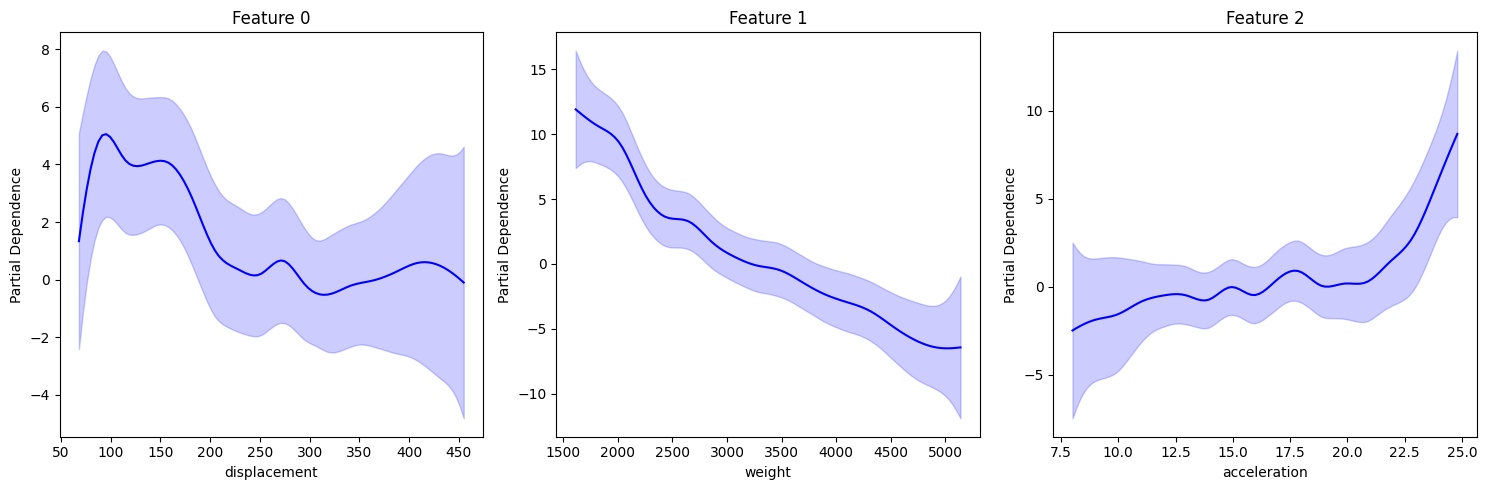

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)  # Generate grid for the i-th term
    pdep, confi = gam.partial_dependence(term=i, width=0.95)
    
    ax.plot(XX[:, i], pdep, color='blue')  # Plot partial dependence
    ax.fill_between(XX[:, i], confi[:,0], confi[:,1], color='blue', alpha=0.2)  # Plot confidence intervals
    ax.set_title(f'Feature {i}')
    ax.set_xlabel(X_auto.columns[i])
    ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

In [36]:
X_new = np.array([[200, 3000, 15], [150, 2500, 12]])  # Example new data
y_pred_new = gam.predict(X_new)
print("Predictions on new data:", y_pred_new)

Predictions on new data: [20.89803233 25.86325255]


In [37]:
mpg_min = 20  # Lower bound of mpg range
mpg_max = 21  # Upper bound of mpg range

# Filter rows where mpg is within the specified range
filtered_auto = auto[(auto['mpg'] >= mpg_min) & (auto['mpg'] <= mpg_max)]

# Display the filtered rows
print(filtered_auto)

      mpg  cylinders  displacement horsepower  weight  acceleration  year  \
17   21.0          6         200.0         85    2587          16.0    70   
24   21.0          6         199.0         90    2648          15.0    70   
60   20.0          4         140.0         90    2408          19.5    72   
61   21.0          4         122.0         86    2226          16.5    72   
78   21.0          4         120.0         87    2979          19.5    72   
108  20.0          4          97.0         88    2279          19.0    73   
109  21.0          4         140.0         72    2401          19.5    73   
113  21.0          6         155.0        107    2472          14.0    73   
119  20.0          4         114.0         91    2582          14.0    73   
123  20.0          6         156.0        122    2807          13.5    73   
125  20.0          6         198.0         95    3102          16.5    74   
126  21.0          6         200.0          ?    2875          17.0    74   

9. This question uses the variables dis (the weighted mean of distances
to five Boston employment centers) and nox (nitrogen oxides concentration in parts per 10 million) from the Boston data. We will treat
dis as the predictor and nox as the response.

In [109]:
boston = load_data('Boston')
boston.columns
dis = boston['dis']
nox = boston['nox']

(a) Use the poly() function from the ISLP.models module to fit a
cubic polynomial regression to predict nox using dis. Report the
regression output, and plot the resulting data and polynomial
fits.

In [42]:
dis_poly = MS([poly('dis',degree=3)]).fit(boston)
mod = sm.OLS(nox,dis_poly.transform(boston)).fit()
summarize(mod)

,coef,std err,t,P>|t|
intercept,0.5547,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.0031,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.8563,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.3180,0.062,-5.124,0.0


In [47]:
mod.mse_resid

0.0038528022055359973

In [73]:
def plot_fit(df,basis,title):
    X = basis.transform(boston)
    Xnew = basis.transform(df)
    M = sm.OLS(nox,X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(3,3))
    ax.scatter(dis,nox,facecolor='gray',alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('dis', fontsize=10)
    ax.set_ylabel('nox', fontsize=10);
    return ax

In [63]:
dis_grid = np.linspace(dis.min(),dis.max(),100)
dis_df = pd.DataFrame({'dis':dis_grid})


<Axes: title={'center': 'dis vs nox'}, xlabel='dis', ylabel='nox'>

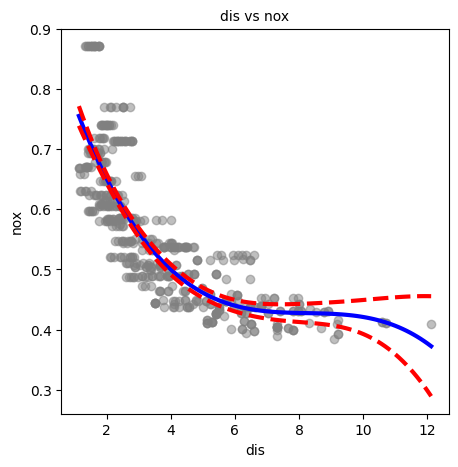

In [64]:
plot_fit(dis_df,dis_poly,'dis vs nox')

(b) Plot the polynomial fits for a range of different polynomial
degrees (say, from 1 to 10), and report the associated residual
sum of squares.

In [74]:
models = [MS([poly('dis',degree=d)]) for d in range(1,11)]
Xs = [md.fit_transform(boston) for md in models]
anova_lm(*[sm.OLS(nox,X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,2.768563,0.0,NaN,NaN,NaN
1,503.0,2.035262,1.0,0.733301,198.116860,3.558589e-38
2,502.0,1.934107,1.0,0.101155,27.329219,2.522104e-07
3,501.0,1.932981,1.0,0.001125,0.304045,5.816033e-01
4,500.0,1.915290,1.0,0.017691,4.779699,2.926006e-02
5,499.0,1.878257,1.0,0.037033,10.005161,1.656138e-03
6,498.0,1.849484,1.0,0.028774,7.773823,5.503632e-03
7,497.0,1.835630,1.0,0.013854,3.742933,5.359844e-02
8,496.0,1.833331,1.0,0.002299,0.621093,4.310180e-01
9,495.0,1.832171,1.0,0.001160,0.313312,5.759079e-01


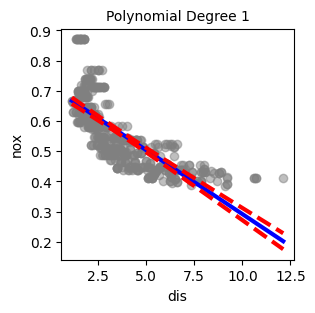

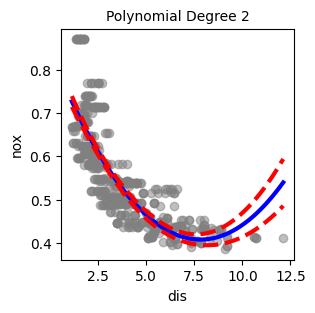

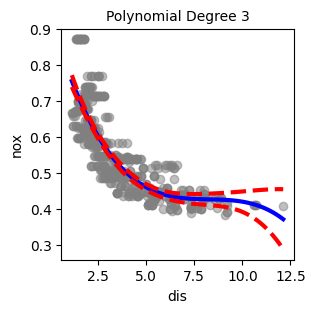

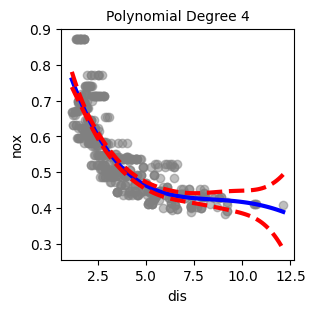

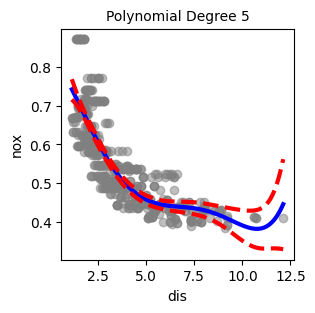

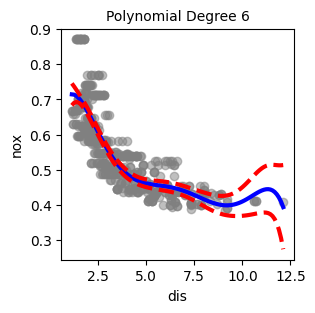

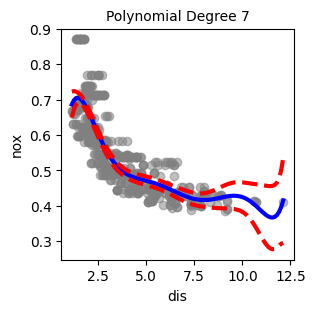

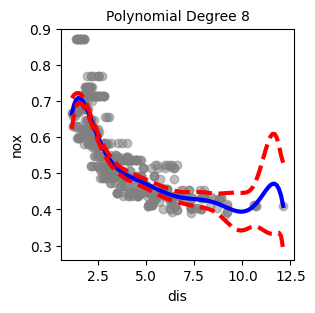

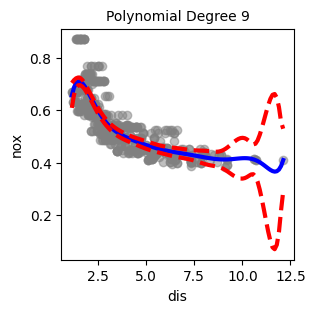

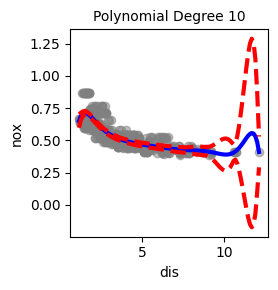

In [75]:
for i, model in enumerate(models):
    title = f'Polynomial Degree {i + 1}'
    plot_fit(dis_df, model, title)

# Show the plots
plt.tight_layout()
plt.show()

(c) Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.

In [86]:
def ols_model(X_train, y_train):
    X_train = sm.add_constant(X_train)  # Adds a constant term for the intercept
    model = sm.OLS(y_train, X_train).fit()
    return model

In [88]:
def custom_score(X, y):
    model = ols_model(X, y)
    predictions = model.predict(sm.add_constant(X))
    return -np.mean((y - predictions) ** 2)  # Return negative MSE

In [96]:
scores = []
for model in models:
    Xs = model.transform(boston)
    Xs = Xs.drop(labels='intercept',axis=1)
    md = LinearRegression()
    scores.append(-1 * np.mean(cross_val_score(md,Xs,nox,scoring='neg_mean_squared_error',cv=5)))
scores



[0.006032109223148164,
 0.004570384881436259,
 0.0046473674594229636,
 0.004756118478675037,
 0.0049696502552255255,
 0.02208332390140221,
 0.08601104446992003,
 2.417994389523743,
 0.13095008788254228,
 84.6494479691431]

- anova suggests using degree 3 is significant, and even though degree 3's cv score is higher than degree 2, degree 3 can be used.

(d) Use the bs() function from the ISLP.models module to fit a regression spline to predict nox using dis. Report the output for
the fit using four degrees of freedom. How did you choose the
knots? Plot the resulting fit

In [121]:
bs_dis = MS([bs('dis', df=4,name='bs(dis)')])
bs_dis.fit(boston)
X_dis = bs_dis.transform(boston)
M = sm.OLS(nox,X_dis).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.7345,0.015,50.306,0.000
bs(dis)[0],-0.0581,0.022,-2.658,0.008
bs(dis)[1],-0.4636,0.024,-19.596,0.000
bs(dis)[2],-0.1998,0.043,-4.634,0.000
bs(dis)[3],-0.3888,0.046,-8.544,0.000


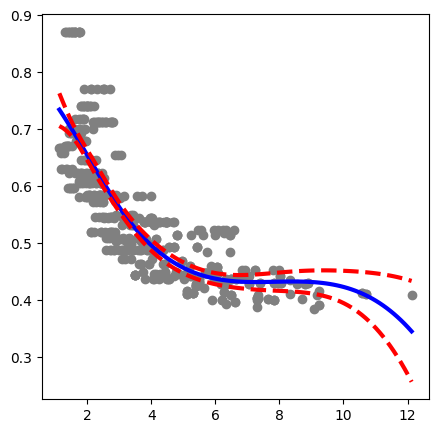

In [127]:
preds_bs = M.get_prediction(bs_dis.transform(dis_df))

fig,ax = subplots(figsize=(5,5))

ax.scatter(dis,nox,facecolor='gray')
bands = preds_bs.conf_int(alpha=0.05)
for val, ls in zip([preds_bs.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
    ax.plot(dis_df.values, val, ls, linewidth=3)

(e) Now fit a regression spline for a range of degrees of freedom, and
plot the resulting fits and report the resulting RSS. Describe the
results obtained.

In [131]:
bs_models = [MS([bs('dis',df=df,name='bs(dis)')]) for df in range(3,12)]
scores = []
for bs_model in bs_models:
    bs_model.fit(boston)
    Xnew = bs_model.transform(boston)
    M = sm.OLS(nox,Xnew).fit()
    scores.append(M.mse_resid * Xnew.shape[0])

scores

[1.9495179160012144,
 1.9419643639976734,
 1.8622548751063859,
 1.8596928797576466,
 1.8592801799943413,
 1.8498983877323296,
 1.8624600206771182,
 1.832368998212937,
 1.8406434449313815]

(f) Perform cross-validation or another approach in order to select
the best degrees of freedom for a regression spline on this data.
Describe your results.

In [133]:
cv_scores = []
for bs_model in bs_models:
    Xnew = bs_model.transform(boston)
    md = LinearRegression()
    Xnew = Xnew.drop(labels='intercept',axis=1)
    cv_scores.append(-1*np.mean(cross_val_score(md,Xnew,nox,cv=5,scoring='neg_mean_squared_error')))

cv_scores
    

[0.004647367459422961,
 0.005179168982316173,
 0.004788388358923626,
 0.005227434315356494,
 0.005209741820397018,
 0.00554468368005356,
 0.005293458502480557,
 0.005638539966779166,
 0.005954520870290646]

- degree 3 gives best result.

10. This question relates to the College data set.

(a) Split the data into a training set and a test set. Using out-of-state
tuition as the response and the other variables as the predictors,
perform forward stepwise selection on the training set in order
to identify a satisfactory model that uses just a subset of the
predictors.

In [135]:
college = load_data('College')
college.columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate'],
      dtype='object')

In [142]:
college_X = college.drop(labels='Outstate',axis=1)
college_y = college['Outstate']

In [153]:
private = np.array(college_X.shape[0] * [False])
private[college_X.Private == 'Yes'] = True
college_X['Private01'] = private
college_X = college_X.drop('Private',axis=1)

In [157]:
college_X['Private01'] = college_X['Private01'].astype(int)
college_X.dtypes

Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Room.Board       int64
Books            int64
Personal         int64
PhD              int64
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
Private01        int32
dtype: object

In [175]:
college_X_train, college_X_test, college_y_train, college_y_test = train_test_split(college_X,college_y,test_size=0.25,shuffle=True,random_state=1)

In [161]:
def forward_Stepwise(X,y,limit):
    remaining_predictors = list(X.columns)
    selected_predictors = []
    best_models = []

    while remaining_predictors:
        scores = []
        if len(selected_predictors) >= limit:
            break
        for predictor in remaining_predictors:
            predictors = selected_predictors + [predictor]
            X_with_predictors = X[predictors]
            X_with_predictors = sm.add_constant(X_with_predictors)
            model = sm.OLS(y,X_with_predictors).fit()

            score = model.aic
            scores.append((score,predictor,model))
        scores.sort()
        best_score, best_predictor, best_model = scores[0]
        best_models.append(best_model)
        selected_predictors.append(best_predictor)
        remaining_predictors.remove(best_predictor)
    return best_models[-1]


In [189]:
college_X_test.columns

Index(['Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad',
       'P.Undergrad', 'Room.Board', 'Books', 'Personal', 'PhD', 'Terminal',
       'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate', 'Private01'],
      dtype='object')

In [191]:
scores = []
for i in range(1,college_X.shape[1]):
    final_model = forward_Stepwise(college_X_train,college_y_train,i)
    selected_predictors = list(final_model.params.index)
    X_test_selected = sm.add_constant(college_X_test[selected_predictors[1:]])
    preds = final_model.predict(X_test_selected)
    scores.append(mean_squared_error(college_y_test,preds))
scores


[9841314.036557276,
 6628397.004878565,
 5087344.980175375,
 4596069.67796296,
 4651033.147165014,
 4448566.551317656,
 4458138.439127671,
 4442663.582147937,
 4414059.293594228,
 4393805.395596554,
 4416546.012746794,
 4176843.175808272,
 4234958.392862949,
 4188313.1501435963,
 4211050.4158063885,
 4206233.950870357]

In [192]:
final_model = forward_Stepwise(college_X_train,college_y_train,5)
predictors = list(final_model.params.index)
predictors

['const', 'Room.Board', 'perc.alumni', 'Expend', 'Private01', 'PhD']

(b) Fit a GAM on the training data, using out-of-state tuition as
the response and the features selected in the previous step as
the predictors. Plot the results, and explain your findings.

In [199]:
college_gam = LinearGAM(s_gam(0) + s_gam(1) + s_gam(2)+ f_gam(3, lam=0) + s_gam(4))
college_X_gam = np.column_stack([college_X_train['Room.Board'],college_X_train['perc.alumni'],college_X_train['Expend'],college_X_train['Private01'],college_X_train['PhD']])
college_gam = college_gam.fit(college_X_gam,college_y_train)


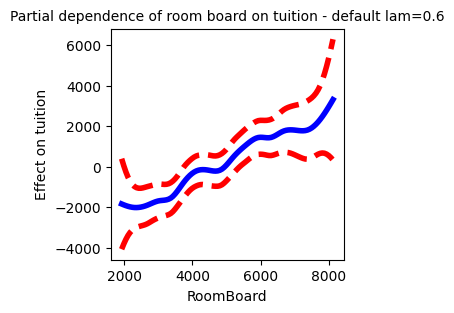

In [222]:
fig, ax = subplots(figsize=(3,3))
plot_gam(college_gam, 0, ax=ax)
ax.set_xlabel('RoomBoard')
ax.set_ylabel('Effect on tuition')
ax.set_title('Partial dependence of room board on tuition - default lam=0.6', fontsize=10);


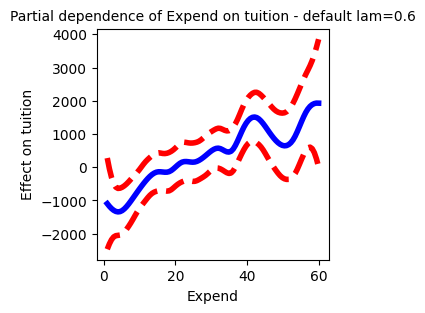

In [204]:
fig, ax = subplots(figsize=(3,3))
plot_gam(college_gam, 1, ax=ax)
ax.set_xlabel('Expend')
ax.set_ylabel('Effect on tuition')
ax.set_title('Partial dependence of Expend on tuition - default lam=0.6', fontsize=10);


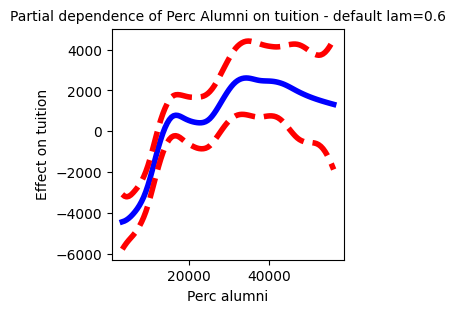

In [208]:
fig, ax = subplots(figsize=(3,3))
plot_gam(college_gam, 2, ax=ax)
ax.set_xlabel('Perc alumni')
ax.set_ylabel('Effect on tuition')
ax.set_title('Partial dependence of Perc Alumni on tuition - default lam=0.6', fontsize=10);


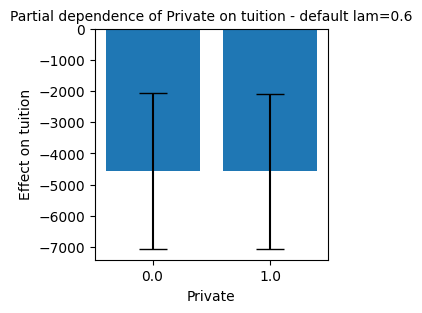

In [209]:
fig, ax = subplots(figsize=(3,3))
plot_gam(college_gam, 3, ax=ax)
ax.set_xlabel('Private')
ax.set_ylabel('Effect on tuition')
ax.set_title('Partial dependence of Private on tuition - default lam=0.6', fontsize=10);


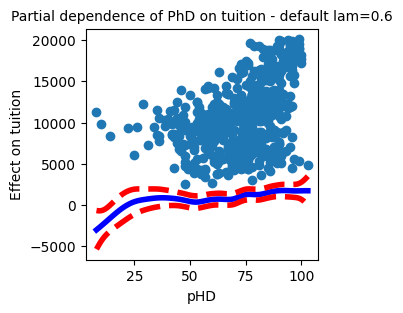

In [218]:
fig, ax = subplots(figsize=(3,3))
plot_gam(college_gam, 4, ax=ax)
ax.scatter(x=college_X.PhD,y=college_y)
ax.set_xlabel('pHD')
ax.set_ylabel('Effect on tuition')
ax.set_title('Partial dependence of PhD on tuition - default lam=0.6', fontsize=10);


(c) Evaluate the model obtained on the test set, and explain the
results obtained.

In [216]:
preds = college_gam.predict(college_X_test[predictors[1:]])
gam_mse= mean_squared_error(college_y_test,preds)
gam_mse

3800169.8574410644

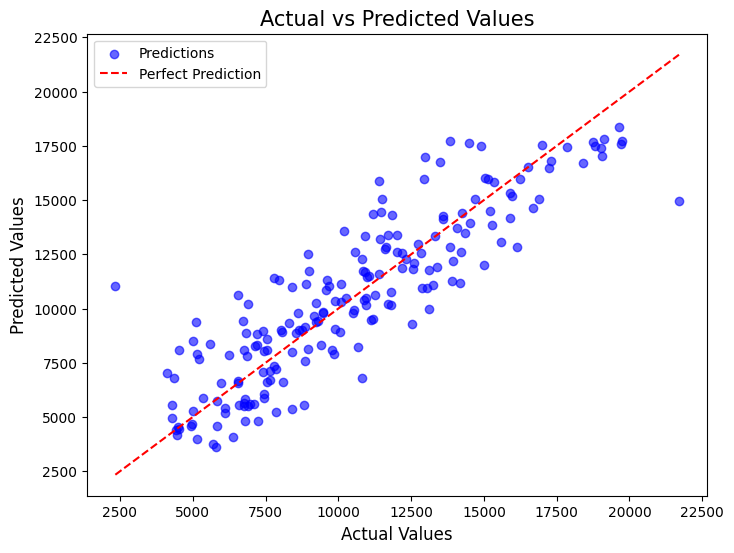

In [223]:
plt.figure(figsize=(8, 6))
plt.scatter(college_y_test, preds, alpha=0.6, color='b', label="Predictions")
plt.plot([min(college_y_test), max(college_y_test)], [min(college_y_test), max(college_y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Add labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted Values', fontsize=15)
plt.legend()

# Show plot
plt.show()

11. In Section 7.7, it was mentioned that GAMs are generally fit using
a backfitting approach. The idea behind backfitting is actually quite
simple. We will now explore backfitting in the context of multiple
linear regression.
Suppose that we would like to perform multiple linear regression, but
we do not have software to do so. Instead, we only have software
to perform simple linear regression. Therefore, we take the following
iterative approach: we repeatedly hold all but one coefficient estimate fixed at its current value, and update only that coefficient
estimate using a simple linear regression. The process is continued until convergence—that is, until the coefficient estimates stop changing.
We now try this out on a toy example.

(a) Generate a response Y and two predictors X1 and X2, with
n = 100.

In [254]:
n = 100

X1 = np.random.normal(0,50,n)
X2 = np.random.normal(0,50,n)

Y = 15 + -9 * X1 + 6* X2 + np.random.normal(0,5,n)



(b) Write a function simple_reg() that takes two arguments outcome
and feature, fits a simple linear regression model with this outcome and feature, and returns the estimated intercept and slope.

In [255]:
def simple_reg(outcome,feature):
    slope = (np.sum((feature - np.mean(feature))* (outcome - np.mean(outcome)))) / np.sum((feature - np.mean(feature))**2) 
    intercept = np.mean(outcome) - slope * np.mean(feature)
    return intercept,slope

(c) Initialize beta1 to take on a value of your choice. It does not
matter what value you choose.

In [257]:
beta1 = 45
beta0, beta2 = simple_reg(Y - beta1*X1, X2)

(e) Keeping beta2 fixed, fit the model
Y − beta2 · X2 = β0 + β1X1 + ϵ.
Store the result as beta0 and beta1 (overwriting their previous
values).

In [258]:
beta0, beta1 = simple_reg(Y - beta2 * X2, X1)

(f) Write a for loop to repeat (c) and (d) 1,000 times. Report the
estimates of beta0, beta1, and beta2 at each iteration of the for
loop. Create a plot in which each of these values is displayed,
with beta0, beta1, and beta2.

In [259]:
beta0_values = []
beta1_values = []
beta2_values = []
for i in range(0,1000):
    beta1 = np.random.rand()
    beta0, beta2 = simple_reg(Y - beta1*X1, X2)
    beta0, beta1 = simple_reg(Y - beta2 * X2, X1)
    beta0_values.append(beta0)
    beta1_values.append(beta1)
    beta2_values.append(beta2)
    print(beta0,beta1,beta2)

14.200793232685907 -8.968902699815189 6.41480490908641
14.202396906603928 -8.968972097754689 6.413508430387736
14.16975625787654 -8.96755959503819 6.439896529184085
14.160001106330967 -8.96713744723797 6.447783011616102
14.182911116976163 -8.96812886295834 6.429261577517773
14.173596685539652 -8.967725787032471 6.436791762932638
14.167667332985882 -8.967469198180355 6.441585305557779
14.160996449572194 -8.96718052006547 6.446978333498168
14.17975387547266 -8.967992235398098 6.431814026809278
14.2013104277983 -8.96892508109527 6.414386786400286
14.192615346724512 -8.9685488071511 6.421416262448191
14.189159690046736 -8.96839926586945 6.424209963351048
14.209129888904256 -8.96926346315826 6.408065199046996
14.197196723444373 -8.968747063231003 6.4177124812361
14.17769564848961 -8.967903166972128 6.43347798567932
14.20291491973177 -8.968994514433852 6.41308964638288
14.179156347851443 -8.96796637778126 6.432297093737077
14.198450334383027 -8.968801312424118 6.416699008447084
14.1651693512

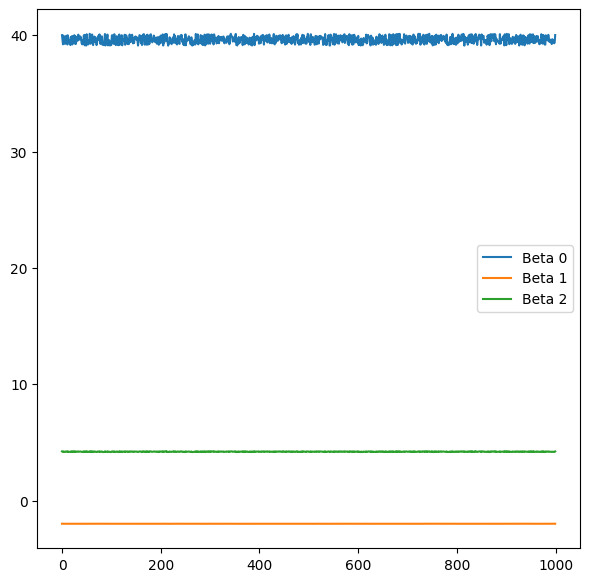

In [251]:
fig,ax = subplots(figsize=(7,7))
ax.plot(beta0_values,label='Beta 0')
ax.plot(beta1_values,label='Beta 1')
ax.plot(beta2_values, label='Beta 2')
ax.legend()

(g) Compare your answer in (e) to the results of simply performing multiple linear regression to predict Y using X1 and X2.
Use axline() method to overlay those multiple linear regression
coefficient estimates on the plot obtained in (e).

In [260]:
linreg = LinearRegression()
result = linreg.fit(pd.DataFrame({'X1':X1,'X2':X2}),Y)
beta1_mlr,beta2_mlr =result.coef_
beta0_mlr = result.intercept_

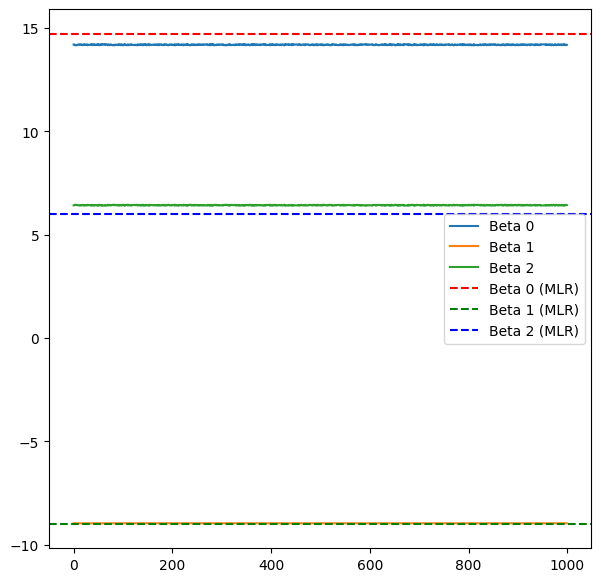

In [261]:
fig,ax = subplots(figsize=(7,7))
ax.plot(beta0_values,label='Beta 0')
ax.plot(beta1_values,label='Beta 1')
ax.plot(beta2_values, label='Beta 2')
ax.axline((0, beta0_mlr), slope=0, color='red', linestyle='--', label='Beta 0 (MLR)')
ax.axline((0, beta1_mlr), slope=0, color='green', linestyle='--', label='Beta 1 (MLR)')
ax.axline((0, beta2_mlr), slope=0, color='blue', linestyle='--', label='Beta 2 (MLR)')
ax.legend()


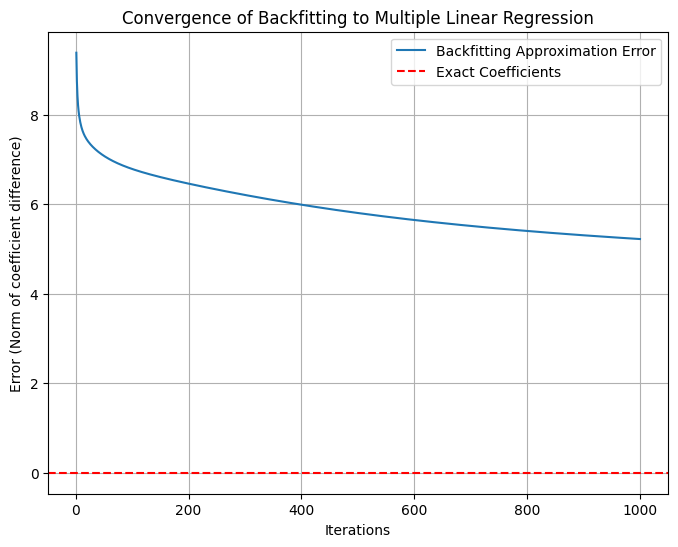

[-1.42462208  0.39191211 -0.14740222  0.39856635 -0.27619435  0.80840077
  0.53112615  0.03561756 -1.07537697 -0.36349117 -1.14336406 -0.58235518
 -0.39991636 -0.38703196 -0.05984954  0.43743427  0.38637322 -0.12106242
 -0.89268076 -0.94598455  0.16580377  0.03752573 -0.51503911  0.86928754
  1.63061907  0.45957625  0.01521796  0.59554102  0.28894614 -0.54665329
 -0.14784089  0.83454488  0.47130048  0.62555059  0.91869423  0.19106543
 -0.53155389  0.32514831 -0.24686288  0.25582075  0.82438231  0.08858813
 -0.75698833 -0.3482221  -0.35737948  0.8744157  -0.94060941 -0.80507429
 -1.19106418 -0.01760119 -0.85484384  1.3480686   1.05373336  0.1655051
 -0.3935018  -0.33460596  0.63933777  0.41310397 -0.0099483   0.95621882
  0.43959009  0.02000448  0.76506865  1.35488579 -0.88783089  0.27836094
 -1.25366754 -1.32663772 -0.12374291  0.57064898  0.53808023 -0.73358462
  0.1535097  -1.24274619 -0.96884671  0.17270605 -0.14287256 -0.15832892
 -1.08057018  1.26262608  1.39061321 -0.73816969  1.

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Step 1: Generate Data
np.random.seed(0)
n = 100  # Number of observations
p = 100  # Number of predictors

X = np.random.normal(size=(n, p))
true_coeffs = np.random.uniform(-1, 1, size=p)  # True coefficients
Y = X @ true_coeffs + np.random.normal(size=n)  # Linear relationship with noise

# Step 2: Initialize coefficients for backfitting
backfit_coeffs = np.zeros(p)

# Function to perform one iteration of backfitting
def backfitting_iteration(X, Y, coeffs):
    for j in range(p):
        # Residual after removing the effect of all predictors except j
        residuals = Y - X @ coeffs + X[:, j] * coeffs[j]
        # Simple linear regression to update the coefficient for predictor j
        model = LinearRegression().fit(X[:, j].reshape(-1, 1), residuals)
        coeffs[j] = model.coef_[0]
    return coeffs

# Step 3: Perform Backfitting
iterations = 1000  # Maximum number of iterations
backfit_coeff_history = []

for i in range(iterations):
    backfitting_iteration(X, Y, backfit_coeffs)
    backfit_coeff_history.append(np.copy(backfit_coeffs))

# Step 4: Compare to multiple linear regression
lin_reg = LinearRegression().fit(X, Y)
lin_reg_coeffs = lin_reg.coef_

# Step 5: Plot Convergence of Coefficients
backfit_coeff_history = np.array(backfit_coeff_history)
error_history = np.linalg.norm(backfit_coeff_history - lin_reg_coeffs, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(1, iterations + 1), error_history, label='Backfitting Approximation Error')
plt.axhline(0, color='red', linestyle='--', label='Exact Coefficients')
plt.xlabel('Iterations')
plt.ylabel('Error (Norm of coefficient difference)')
plt.title('Convergence of Backfitting to Multiple Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

print(backfit_coeffs)
print(lin_reg_coeffs)
threshold = 1e-2
good_approximation = np.where(error_history < threshold)[0]
# Step 6: Print the number of iterations required for good approximation
if good_approximation.size > 0:
    print(f'A good approximation to the multiple regression coefficients was achieved after {good_approximation[0] + 1} iterations.')
else:
    print(f'No approximation met the threshold of {threshold}. Try increasing the number of iterations.')


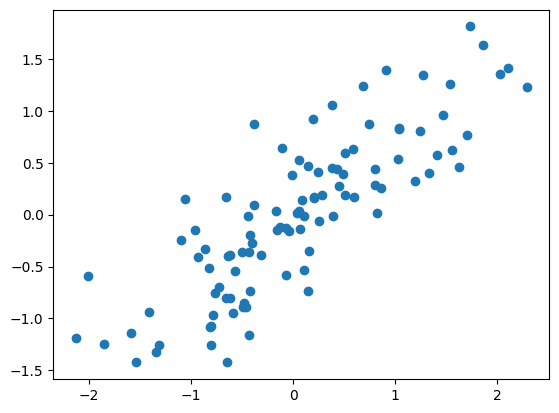

In [272]:
plt.scatter(x=lin_reg_coeffs,y=backfit_coeffs)